In [2]:
!pip install pyts
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tensorflow as tf
from keras_tuner import HyperModel
from sklearn import metrics
from pyts.image import GramianAngularField
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from keras import backend as K

# Step 1 Data Preparation

## Original Time Series

The dataset used in this project contains 1-minute bars of S&P 500 during Feb 15, 2024. downloaded from https://www.histdata.com/download-free-forex-historical-data/. The file is in Excel format and has been zipped alongside this notebook.

In [3]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving SP500 15.02.2024.xlsx to SP500 15.02.2024.xlsx


In [7]:
df = pd.read_excel('/content/SP500 15.02.2024.xlsx')
df.columns = ['Date', "Time", "Open", "High", "Low", "Close"]
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.set_index('DateTime', inplace=True)
df = df.drop(columns=['Date', "Time", "Open",	'High',	'Low'])
df.head(10)

,Close
DateTime,
2024-02-15 00:01:00,5002.376
2024-02-15 00:02:00,5002.864
2024-02-15 00:03:00,5002.629
2024-02-15 00:04:00,5002.876
2024-02-15 00:05:00,5002.611
2024-02-15 00:06:00,5002.370
2024-02-15 00:07:00,5002.427
2024-02-15 00:09:00,5002.427
2024-02-15 00:10:00,5002.047


There is data missing at 00:08:00.

In [8]:
df.shape

(1271, 1)

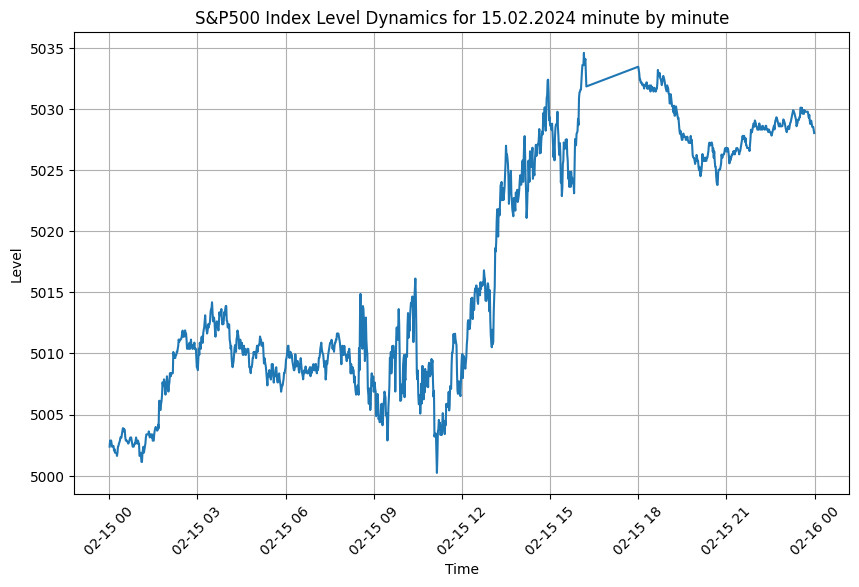

In [9]:
# Plot time series
plt.figure(figsize=(10, 6))
plt.plot(df['Close'])
plt.title('S&P500 Index Level Dynamics for 15.02.2024 minute by minute')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid(True)
plt.xticks(rotation= 45)
plt.show()

The full 1-min price data of a day should contain $24 \times 60= 1440$ rows. After some inspection, there is no data between 16:15 and 18:00 each day, during which the U.S. stock market is closed.

To avoid any implication of this discontinuation, we decide to separate this data into two time series, one for training and the other for testing.

In [10]:
df1 = df[df.index <= '2024-02-15 16:15:00']
df1 = df1.reindex(pd.date_range(start=df1.index[0], end=df1.index[-1], freq='min'))
df1 = df1.fillna(method='pad')

print(df1.shape)
df1.tail(10)

(974, 1)


,Close
2024-02-15 16:05:00,5033.061
2024-02-15 16:06:00,5033.582
2024-02-15 16:07:00,5033.573
2024-02-15 16:08:00,5033.561
2024-02-15 16:09:00,5034.567
2024-02-15 16:10:00,5033.567
2024-02-15 16:11:00,5033.826
2024-02-15 16:12:00,5034.079
2024-02-15 16:13:00,5032.842
2024-02-15 16:14:00,5031.824


In [11]:
df2 = df[df.index > '2024-02-15 16:15:00']
df2 = df2.reindex(pd.date_range(start=df2.index[0], end=df2.index[-1], freq='min'))
df2 = df2.fillna(method='pad')

print(df2.shape)
df2.head(10)

(360, 1)


,Close
2024-02-15 18:00:00,5033.437
2024-02-15 18:01:00,5033.143
2024-02-15 18:02:00,5032.887
2024-02-15 18:03:00,5032.381
2024-02-15 18:04:00,5032.390
2024-02-15 18:05:00,5032.134
2024-02-15 18:06:00,5032.146
2024-02-15 18:07:00,5032.137
2024-02-15 18:08:00,5031.947
2024-02-15 18:09:00,5032.029


Text(0, 0.5, 'Frequency')

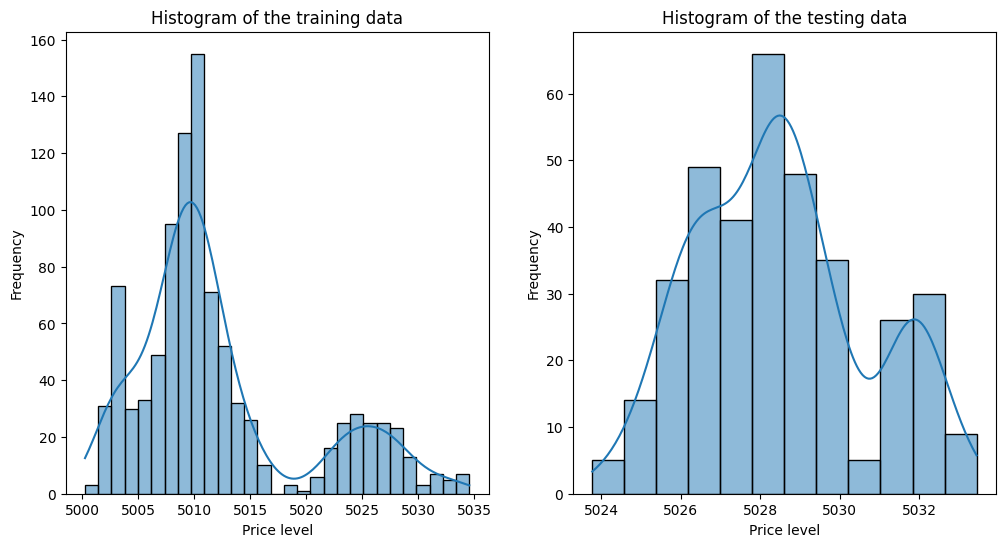

In [12]:
# Create the histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df1['Close'], kde=True)
plt.title('Histogram of the training data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df2['Close'], kde=True)
plt.title('Histogram of the testing data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

In [13]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df1['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                  -0.625607
P-value                          0.865090
#Lags Used                       4.000000
Number of Observations Used    969.000000
Critical Value (1%)             -3.437116
Critical Value (5%)             -2.864527
Critical Value (10%)            -2.568361
dtype: float64


In [14]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df2['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                  -2.326153
P-value                          0.163672
#Lags Used                       0.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


Both p-values are greater than 0.05, so we fail to reject the null hypothesis and this suggests that the time series is not stationary.

## Stationary Time Series


In [15]:
df1_diff = df1['Close'].diff()[1:].to_frame()

(array([19768.        , 19768.08333333, 19768.16666667, 19768.25      ,
        19768.33333333, 19768.41666667, 19768.5       , 19768.58333333,
        19768.66666667]),
 [Text(19768.0, 0, '02-15 00'),
  Text(19768.083333333332, 0, '02-15 02'),
  Text(19768.166666666668, 0, '02-15 04'),
  Text(19768.25, 0, '02-15 06'),
  Text(19768.333333333332, 0, '02-15 08'),
  Text(19768.416666666668, 0, '02-15 10'),
  Text(19768.5, 0, '02-15 12'),
  Text(19768.583333333332, 0, '02-15 14'),
  Text(19768.666666666668, 0, '02-15 16')])

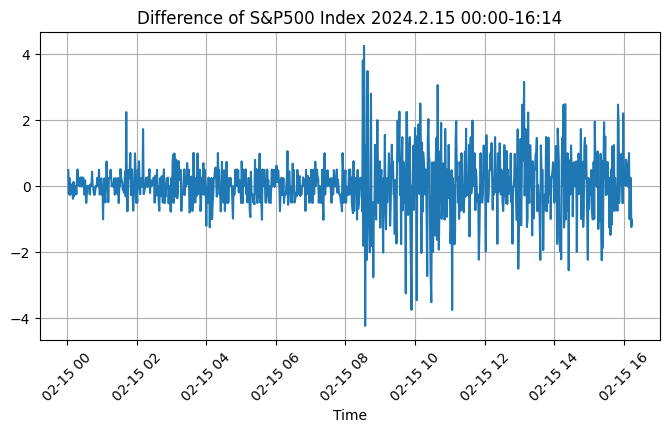

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(df1_diff['Close'])
plt.title('Difference of S&P500 Index 2024.2.15 00:00-16:14')
plt.xlabel('Time')
plt.grid(True)
plt.xticks(rotation= 45)

In [17]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df1_diff['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                -1.755825e+01
P-value                        4.109165e-30
#Lags Used                     3.000000e+00
Number of Observations Used    9.690000e+02
Critical Value (1%)           -3.437116e+00
Critical Value (5%)           -2.864527e+00
Critical Value (10%)          -2.568361e+00
dtype: float64


The p-values is smaller than 0.05, so we reject the null hypothesis, meaning that the new series has no unit root and thus is stationary.

In [18]:
df2_diff = df2['Close'].diff()[1:].to_frame()

(array([19768.75      , 19768.79166667, 19768.83333333, 19768.875     ,
        19768.91666667, 19768.95833333, 19769.        ]),
 [Text(19768.75, 0, '02-15 18'),
  Text(19768.791666666668, 0, '02-15 19'),
  Text(19768.833333333332, 0, '02-15 20'),
  Text(19768.875, 0, '02-15 21'),
  Text(19768.916666666668, 0, '02-15 22'),
  Text(19768.958333333332, 0, '02-15 23'),
  Text(19769.0, 0, '02-16 00')])

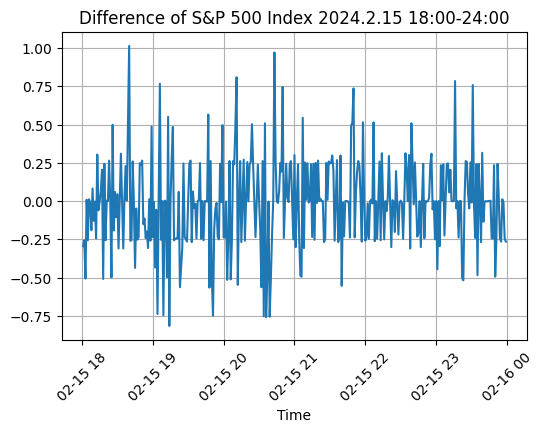

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(df2_diff['Close'])
plt.title('Difference of S&P 500 Index 2024.2.15 18:00-24:00')
plt.xlabel('Time')
plt.grid(True)
plt.xticks(rotation= 45)

In [21]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df2_diff['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                 -19.582866
P-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


The p-values is zero, so we reject the null hypothesis, meaning that the new series has no unit root and thus is stationary.

## Fractional Differencing

In [23]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1)
    return w

def cutoff_find(order,cutoff,start_lags):
    # order is our dearest d, cutoff is 1e-4 for us, and start
    # lags is an initial amount of lags in which the loop will start,
    # this can be set to high values in order to speed up the algo
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags

def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    # print(lag_cutoff)
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [24]:
possible_d=np.divide(range(5,101,5),100)
tau = 1e-3
original_adf_stat_holder1=[None]*len(possible_d)
original_adf_stat_holder2=[None]*len(possible_d)

for i in range(len(possible_d)):
    original_adf_stat_holder1[i]=adfuller(ts_differencing_tau(df1['Close'],possible_d[i],tau))[1]
    original_adf_stat_holder2[i]=adfuller(ts_differencing_tau(df2['Close'],possible_d[i],tau))[1]

Text(0.5, 1.0, 'ADF P-value by differencing order in the original series for testing')

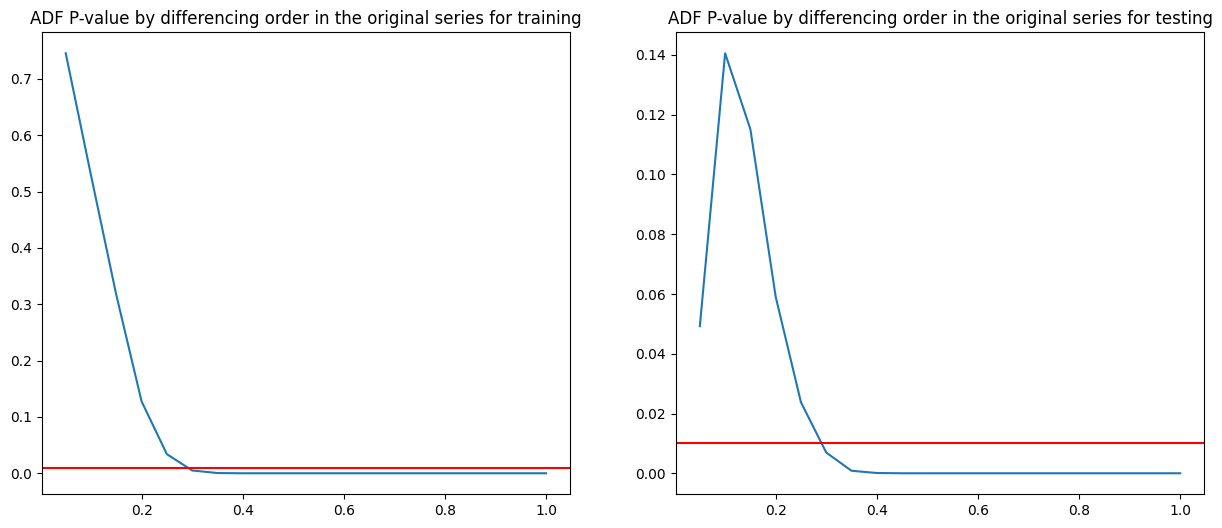

In [25]:
#now the plots of the ADF p-values
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(possible_d,original_adf_stat_holder1)
axs[0].axhline(y=0.01,color='r')
axs[0].set_title('ADF P-value by differencing order in the original series for training')
axs[1].plot(possible_d,original_adf_stat_holder2)
axs[1].axhline(y=0.01,color='r')
axs[1].set_title('ADF P-value by differencing order in the original series for testing')

"Larger time series would allow smaller cutoff values in order to preserve more memory, it ends up being a trade-off between memory conservation and computational efficiency. In short time series however, you might want to stay away from low threshold values, since they can (and will) greatly diminish the size of your training set."  [https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing/notebook]

Since our data set is small, we choose the cutoff value a bit higher at 0.001.
From the graph we can see that 0.4 seems to be a good choice for the order of differencing.

In [26]:
cutoff_find(0.4,tau,1)

57

In [27]:
cutoff_find(0.6,tau,1)

36

In [28]:
cutoff_find(0.8,tau,1)

20

For analysis purpose, we still choose 0.6 as the order so that the cutoff lag would be 36.

In [29]:
df1_fdiff = ts_differencing_tau(df1, 0.6, tau)

(array([19768.        , 19768.08333333, 19768.16666667, 19768.25      ,
        19768.33333333, 19768.41666667, 19768.5       , 19768.58333333,
        19768.66666667]),
 [Text(19768.0, 0, '02-15 00'),
  Text(19768.083333333332, 0, '02-15 02'),
  Text(19768.166666666668, 0, '02-15 04'),
  Text(19768.25, 0, '02-15 06'),
  Text(19768.333333333332, 0, '02-15 08'),
  Text(19768.416666666668, 0, '02-15 10'),
  Text(19768.5, 0, '02-15 12'),
  Text(19768.583333333332, 0, '02-15 14'),
  Text(19768.666666666668, 0, '02-15 16')])

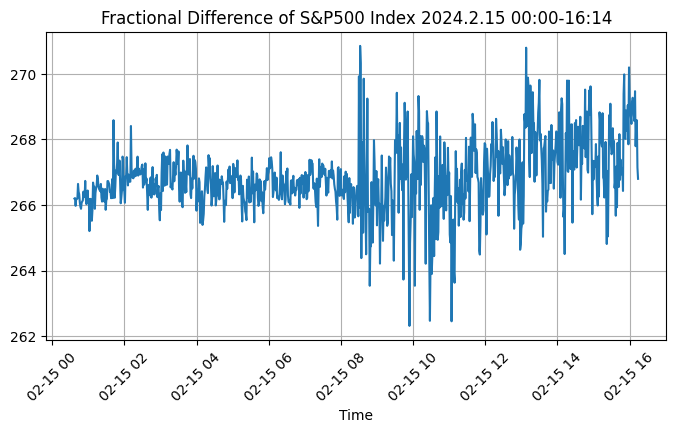

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(df1_fdiff)
plt.title('Fractional Difference of S&P500 Index 2024.2.15 00:00-16:14')
plt.xlabel('Time')
plt.grid(True)
plt.xticks(rotation= 45)

In [31]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df1_fdiff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                -8.024246e+00
P-value                        2.037448e-12
#Lags Used                     4.000000e+00
Number of Observations Used    9.330000e+02
Critical Value (1%)           -3.437378e+00
Critical Value (5%)           -2.864643e+00
Critical Value (10%)          -2.568422e+00
dtype: float64


In [32]:
df2_fdiff = ts_differencing_tau(df2, 0.6, tau)

(array([19768.79166667, 19768.83333333, 19768.875     , 19768.91666667,
        19768.95833333, 19769.        ]),
 [Text(19768.791666666668, 0, '02-15 19'),
  Text(19768.833333333332, 0, '02-15 20'),
  Text(19768.875, 0, '02-15 21'),
  Text(19768.916666666668, 0, '02-15 22'),
  Text(19768.958333333332, 0, '02-15 23'),
  Text(19769.0, 0, '02-16 00')])

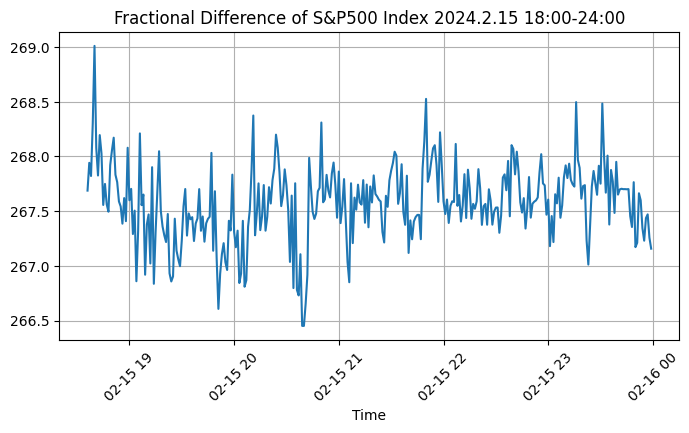

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(df2_fdiff)
plt.title('Fractional Difference of S&P500 Index 2024.2.15 18:00-24:00')
plt.xlabel('Time')
plt.grid(True)
plt.xticks(rotation= 45)

In [34]:
# Perform ADF test
print('Results of ADF Test:')
dftest = adfuller(df2_fdiff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of ADF Test:
Test Statistic                -7.063537e+00
P-value                        5.149908e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.220000e+02
Critical Value (1%)           -3.450823e+00
Critical Value (5%)           -2.870558e+00
Critical Value (10%)          -2.571575e+00
dtype: float64


# Step 2 MLP

## Setup

We define the label as whether the 15 min return in the future is positive.

In [35]:
def add_label(df_in):
  df = df_in.copy()
  df["Ret"] = df["Close"].pct_change()
  df["Ret15_i"] = df["Ret"].rolling(15).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
  df["Ret15_i"] = df["Ret15_i"].shift(-15)
  df["Label"] = df["Ret15_i"] > 0
  df["Label"] = df["Label"].astype(int)
  df.drop(columns=['Ret'], inplace=True)
  return df.dropna()

In [36]:
df1_label = add_label(df1)

In [37]:
df1_label.head()

,Close,Ret15_i,Label
2024-02-15 00:01:00,5002.376,-1.517235e-04,0
2024-02-15 00:02:00,5002.864,-1.986933e-04,0
2024-02-15 00:03:00,5002.629,-4.995853e-05,0
2024-02-15 00:04:00,5002.876,-8.973710e-05,0
2024-02-15 00:05:00,5002.611,6.142571e-07,1


In [38]:
df1_label.tail()

,Close,Ret15_i,Label
2024-02-15 15:55:00,5028.027,0.001101,1
2024-02-15 15:56:00,5028.197,0.001119,1
2024-02-15 15:57:00,5029.177,0.000974,1
2024-02-15 15:58:00,5028.661,0.000831,1
2024-02-15 15:59:00,5030.871,0.000190,1


In [39]:
df1_label.Label.value_counts()

1    543
0    416
Name: Label, dtype: int64

In [40]:
df2_label = add_label(df2)
df2_label.Label.value_counts()

0    185
1    160
Name: Label, dtype: int64

We can see this label setup is quite balanced.

As we need to compare MLP with CNN on GAF later, we will use the same length of past information.

For demonstration purpose, if we want to use window size 20 in the GAP representation, then we can use 20 data points as length of past information.

Therefore, we simply use the past 19 minutes data plus the current minute data as features.

In [41]:
feature_lst = ['Close'] + ["Past_{}min".format(i) for i in range(1, 20)]
print(feature_lst)

['Close', 'Past_1min', 'Past_2min', 'Past_3min', 'Past_4min', 'Past_5min', 'Past_6min', 'Past_7min', 'Past_8min', 'Past_9min', 'Past_10min', 'Past_11min', 'Past_12min', 'Past_13min', 'Past_14min', 'Past_15min', 'Past_16min', 'Past_17min', 'Past_18min', 'Past_19min']


In [45]:
def add_features(df_in, name='Close', set_zero=False):
  df = df_in.copy()
  for i in range(1, 20):
    feat = feature_lst[i]
    if set_zero:
      df[feat] = df[name].shift(i) - df[name]
    else:
      df[feat] = df[name].shift(i)
  return df.dropna()

In [46]:
df1_feature = add_features(df1_label)

In [47]:
df1_feature.head()

,Close,Ret15_i,Label,Past_1min,Past_2min,Past_3min,Past_4min,Past_5min,Past_6min,Past_7min,...,Past_10min,Past_11min,Past_12min,Past_13min,Past_14min,Past_15min,Past_16min,Past_17min,Past_18min,Past_19min
2024-02-15 00:20:00,5002.614,0.000052,1,5002.427,5002.379,5001.870,5001.617,5001.864,5001.873,5001.873,...,5002.047,5002.427,5002.427,5002.427,5002.370,5002.611,5002.876,5002.629,5002.864,5002.376
2024-02-15 00:21:00,5002.614,0.000051,1,5002.614,5002.427,5002.379,5001.870,5001.617,5001.864,5001.873,...,5002.177,5002.047,5002.427,5002.427,5002.427,5002.370,5002.611,5002.876,5002.629,5002.864
2024-02-15 00:22:00,5002.861,0.000002,1,5002.614,5002.614,5002.427,5002.379,5001.870,5001.617,5001.864,...,5001.873,5002.177,5002.047,5002.427,5002.427,5002.427,5002.370,5002.611,5002.876,5002.629
2024-02-15 00:23:00,5003.126,-0.000051,0,5002.861,5002.614,5002.614,5002.427,5002.379,5001.870,5001.617,...,5001.873,5001.873,5002.177,5002.047,5002.427,5002.427,5002.427,5002.370,5002.611,5002.876
2024-02-15 00:24:00,5003.126,-0.000101,0,5003.126,5002.861,5002.614,5002.614,5002.427,5002.379,5001.870,...,5001.873,5001.873,5001.873,5002.177,5002.047,5002.427,5002.427,5002.427,5002.370,5002.611


Notice that for the original index level time series, the absolute value is quite large. Given limited training data, we can subtract the "Close" from all past values so that neural networks can be trained more easily.

In [48]:
df1_feature = add_features(df1_label, set_zero = True)
df1_feature.head()

,Close,Ret15_i,Label,Past_1min,Past_2min,Past_3min,Past_4min,Past_5min,Past_6min,Past_7min,...,Past_10min,Past_11min,Past_12min,Past_13min,Past_14min,Past_15min,Past_16min,Past_17min,Past_18min,Past_19min
2024-02-15 00:20:00,5002.614,0.000052,1,-0.187,-0.235,-0.744,-0.997,-0.750,-0.741,-0.741,...,-0.567,-0.187,-0.187,-0.187,-0.244,-0.003,0.262,0.015,0.250,-0.238
2024-02-15 00:21:00,5002.614,0.000051,1,0.000,-0.187,-0.235,-0.744,-0.997,-0.750,-0.741,...,-0.437,-0.567,-0.187,-0.187,-0.187,-0.244,-0.003,0.262,0.015,0.250
2024-02-15 00:22:00,5002.861,0.000002,1,-0.247,-0.247,-0.434,-0.482,-0.991,-1.244,-0.997,...,-0.988,-0.684,-0.814,-0.434,-0.434,-0.434,-0.491,-0.250,0.015,-0.232
2024-02-15 00:23:00,5003.126,-0.000051,0,-0.265,-0.512,-0.512,-0.699,-0.747,-1.256,-1.509,...,-1.253,-1.253,-0.949,-1.079,-0.699,-0.699,-0.699,-0.756,-0.515,-0.250
2024-02-15 00:24:00,5003.126,-0.000101,0,0.000,-0.265,-0.512,-0.512,-0.699,-0.747,-1.256,...,-1.253,-1.253,-1.253,-0.949,-1.079,-0.699,-0.699,-0.699,-0.756,-0.515


For the other two stationary time series, we may choose to keep as it is.

## Original Time Series

For the original time series, we have subtracted "Close" from the past information and therefore we can exclude it from the features.

In [49]:
df1_feature = add_features(df1_label, set_zero=True)
X_train = df1_feature[feature_lst[1:]].astype("float32")
y_train = df1_feature['Label'].astype("float32")

df2_feature = add_features(df2_label, set_zero=True)
X_test = df2_feature[feature_lst[1:]].astype("float32")
y_test = df2_feature['Label'].astype("float32")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(940, 19) (326, 19) (940,) (326,)


We use Keras Tuner for hyperparameter tuning.

In [50]:
class MLP_model(HyperModel):
    def build(self, hp):
        # We define a constant activation function of ReLU form. We will not be tuning the activation functions
        act_fun = "relu"

        # We do ask the Keras Tuner to choose whether is best to have a dropout rate after each hidden layer of 0, 0.2 or 0.3
        n_dropout = hp.Choice("n_dropout", values=[0.0, 0.20, 0.30])

        model = tf.keras.models.Sequential()

        # Now, we will use a loop to let the tuner choose the number of layers that is best for the model between 1 and 5
        for i in range(1, hp.Int("num_layers", 1, 5)):
            # Within this loop, we will also ask the tuner to decide the optimal number of units that each of the selected layer should have.
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int(
                        "units_dense_" + str(i), min_value=10, max_value=50, step=10
                    ),
                    activation=act_fun,
                )
            )
            model.add(tf.keras.layers.Dropout(n_dropout))

        model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

        # As was the case with the activation function, there is no tuning on the learning rate, nor the optimizer, although we could easily incorporate it.
        hp_lr = 1e-5
        adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
        model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

        return model

We use 30% of the training set as validation set during hyperparameter tuning, and the best set of hyperparameters is selected according to the minimum validation loss.

In [53]:
# First, we clear the session just to make sure our seeds are correctly working and replicability is achieved
K.clear_session()
tf.random.set_seed(1234)

# Then, we call the model and perform the tuning:
hypermodel = MLP_model()
tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_epochs=30,
    seed=1234,
    directory=os.path.normpath("/content/"),
)

# Let's run the tuner!
tuner.search(X_train, y_train, validation_split=0.3)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 07s]
val_loss: 0.6406893730163574

Best val_loss So Far: 0.6406893730163574
Total elapsed time: 00h 04m 46s


In [54]:
best_hps.values

{'n_dropout': 0.0,
 'num_layers': 4,
 'units_dense_1': 50,
 'units_dense_2': 30,
 'units_dense_3': 10,
 'units_dense_4': 20,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [55]:
K.clear_session()
tf.random.set_seed(1234)
model = tuner.hypermodel.build(best_hps)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

# fit the model
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
24/24 - 1s - loss: 0.7644 - accuracy: 0.4761 - val_loss: 0.7149 - val_accuracy: 0.5479 - 1s/epoch - 61ms/step
Epoch 2/500
24/24 - 0s - loss: 0.7597 - accuracy: 0.4761 - val_loss: 0.7100 - val_accuracy: 0.5479 - 80ms/epoch - 3ms/step
Epoch 3/500
24/24 - 0s - loss: 0.7551 - accuracy: 0.4801 - val_loss: 0.7057 - val_accuracy: 0.5585 - 83ms/epoch - 3ms/step
Epoch 4/500
24/24 - 0s - loss: 0.7508 - accuracy: 0.4827 - val_loss: 0.7017 - val_accuracy: 0.5638 - 81ms/epoch - 3ms/step
Epoch 5/500
24/24 - 0s - loss: 0.7467 - accuracy: 0.4854 - val_loss: 0.6976 - val_accuracy: 0.5638 - 80ms/epoch - 3ms/step
Epoch 6/500
24/24 - 0s - loss: 0.7427 - accuracy: 0.4894 - val_loss: 0.6939 - val_accuracy: 0.5638 - 92ms/epoch - 4ms/step
Epoch 7/500
24/24 - 0s - loss: 0.7389 - accuracy: 0.4960 - val_loss: 0.6904 - val_accuracy: 0.5798 - 104ms/epoch - 4ms/step
Epoch 8/500
24/24 - 0s - loss: 0.7352 - accuracy: 0.5013 - val_loss: 0.6873 - val_accuracy: 0.5798 - 86ms/epoch - 4ms/step
Epoch 9/500
24/2

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1000      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

11/11 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.4540
Accuracy over test: 45.40%
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.30      0.04      0.07       169
         1.0       0.47      0.90      0.61       157

    accuracy                           0.45       326
   macro avg       0.38      0.47      0.34       326
weighted avg       0.38      0.45      0.33       326



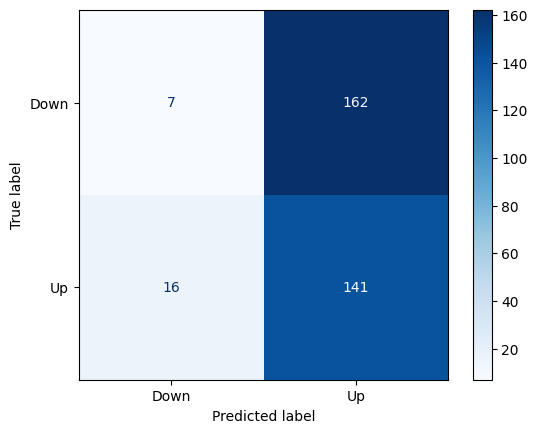

In [57]:
acc = model.evaluate(x=X_test, y=y_test)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model.predict(X_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test, y_pred))

Due to the nature of the problem setup, this hyperparameter tuning process is very unstable. We found that the following network structure can produce good results. Therefore, we will stick with this structure, and will try it for the other time series as well.

In [58]:
best_hps_bk = {'n_dropout': 0.0,
 'num_layers': 5,
 'units_dense_1': 10,
 'units_dense_2': 50,
 'units_dense_3': 50,
 'units_dense_4': 10,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3
}

In [68]:
def build_MLP_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=10, activation='relu'))
    model.add(tf.keras.layers.Dense(units=50, activation='relu'))
    model.add(tf.keras.layers.Dense(units=50, activation='relu'))
    model.add(tf.keras.layers.Dense(units=10, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    hp_lr = 1e-5
    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
    return model

In [92]:
model = build_MLP_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

# fit the model
model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
21/21 - 1s - loss: 0.7066 - accuracy: 0.5015 - val_loss: 0.7200 - val_accuracy: 0.5248 - 1s/epoch - 66ms/step
Epoch 2/500
21/21 - 0s - loss: 0.6617 - accuracy: 0.5866 - val_loss: 0.7552 - val_accuracy: 0.5177 - 86ms/epoch - 4ms/step
Epoch 3/500
21/21 - 0s - loss: 0.6522 - accuracy: 0.6018 - val_loss: 0.6904 - val_accuracy: 0.5780 - 90ms/epoch - 4ms/step
Epoch 4/500
21/21 - 0s - loss: 0.6499 - accuracy: 0.5942 - val_loss: 0.7769 - val_accuracy: 0.5284 - 91ms/epoch - 4ms/step
Epoch 5/500
21/21 - 0s - loss: 0.6389 - accuracy: 0.6292 - val_loss: 0.6961 - val_accuracy: 0.5674 - 82ms/epoch - 4ms/step
Epoch 6/500
21/21 - 0s - loss: 0.6366 - accuracy: 0.6277 - val_loss: 0.7759 - val_accuracy: 0.5177 - 89ms/epoch - 4ms/step
Epoch 7/500
21/21 - 0s - loss: 0.6370 - accuracy: 0.6277 - val_loss: 0.7660 - val_accuracy: 0.5248 - 94ms/epoch - 4ms/step
Epoch 8/500
21/21 - 0s - loss: 0.6292 - accuracy: 0.6550 - val_loss: 0.7696 - val_accuracy: 0.5248 - 80ms/epoch - 4ms/step
Epoch 9/500
21/21

11/11 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5307
Accuracy over test: 53.07%
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.60      0.28      0.39       169
         1.0       0.51      0.80      0.62       157

    accuracy                           0.53       326
   macro avg       0.55      0.54      0.50       326
weighted avg       0.56      0.53      0.50       326



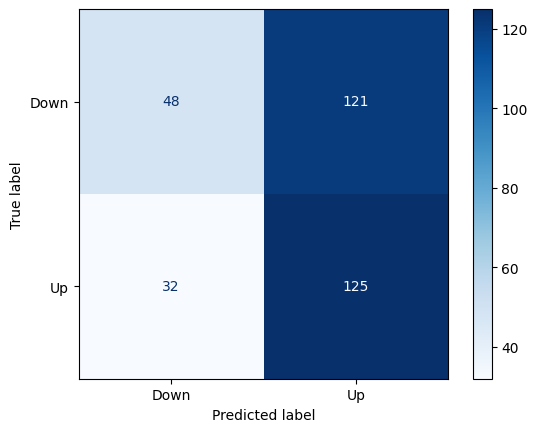

In [93]:
acc = model.evaluate(x=X_test, y=y_test)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model.predict(X_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test, y_pred))

## Stationary Time Series

In [77]:
df1_label_diff = df1_diff.copy()
df1_label_diff['Label'] = df1_label[df1_label.index.isin(df1_diff.index)]['Label']
df1_label_diff.dropna(inplace=True)

df2_label_diff = df2_diff.copy()
df2_label_diff['Label'] = df2_label[df2_label.index.isin(df2_diff.index)]['Label']
df2_label_diff.dropna(inplace=True)

In [79]:
df1_feature_diff = add_features(df1_label_diff)
X_train_diff = df1_feature_diff[feature_lst].astype("float32")
y_train_diff = df1_feature_diff['Label'].astype("float32")

df2_feature_diff = add_features(df2_label_diff)
X_test_diff = df2_feature_diff[feature_lst].astype("float32")
y_test_diff = df2_feature_diff['Label'].astype("float32")
print(X_train_diff.shape, X_test_diff.shape, y_train_diff.shape, y_test_diff.shape)

(939, 20) (325, 20) (939,) (325,)


In [80]:
# First, we clear the session just to make sure our seeds are correctly working and replicability is achieved
K.clear_session()

# Then, we call the model and perform the tuning:
hypermodel = MLP_model()
tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_epochs=30,
    seed=1234,
    directory=os.path.normpath("/content/"),
)

# Let's run the tuner! (Warning: this could take time)
tuner.search(X_train_diff, y_train_diff, validation_split=0.3)
best_hps_diff = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 06s]
val_loss: 0.6689453721046448

Best val_loss So Far: 0.6381919384002686
Total elapsed time: 00h 05m 17s


In [81]:
best_hps_diff.values

{'n_dropout': 0.0,
 'num_layers': 5,
 'units_dense_1': 10,
 'units_dense_2': 50,
 'units_dense_3': 50,
 'units_dense_4': 10,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [82]:
model_diff = tuner.hypermodel.build(best_hps_diff)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

# fit the model
model_diff.fit(
    X_train_diff,
    y_train_diff,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
24/24 - 1s - loss: 0.7035 - accuracy: 0.4647 - val_loss: 0.7531 - val_accuracy: 0.3830 - 1s/epoch - 57ms/step
Epoch 2/500
24/24 - 0s - loss: 0.7032 - accuracy: 0.4634 - val_loss: 0.7519 - val_accuracy: 0.3830 - 90ms/epoch - 4ms/step
Epoch 3/500
24/24 - 0s - loss: 0.7028 - accuracy: 0.4674 - val_loss: 0.7510 - val_accuracy: 0.3830 - 85ms/epoch - 4ms/step
Epoch 4/500
24/24 - 0s - loss: 0.7025 - accuracy: 0.4674 - val_loss: 0.7498 - val_accuracy: 0.3830 - 95ms/epoch - 4ms/step
Epoch 5/500
24/24 - 0s - loss: 0.7022 - accuracy: 0.4634 - val_loss: 0.7488 - val_accuracy: 0.3830 - 110ms/epoch - 5ms/step
Epoch 6/500
24/24 - 0s - loss: 0.7019 - accuracy: 0.4660 - val_loss: 0.7480 - val_accuracy: 0.3777 - 85ms/epoch - 4ms/step
Epoch 7/500
24/24 - 0s - loss: 0.7016 - accuracy: 0.4700 - val_loss: 0.7469 - val_accuracy: 0.3777 - 79ms/epoch - 3ms/step
Epoch 8/500
24/24 - 0s - loss: 0.7013 - accuracy: 0.4674 - val_loss: 0.7461 - val_accuracy: 0.3777 - 90ms/epoch - 4ms/step
Epoch 9/500
24/2

In [83]:
model_diff.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                550       
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

11/11 [==============================] - 0s 2ms/step - loss: 0.6976 - accuracy: 0.5015
Accuracy over test: 50.15%
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.05      0.10       168
         1.0       0.49      0.98      0.66       157

    accuracy                           0.50       325
   macro avg       0.62      0.52      0.38       325
weighted avg       0.63      0.50      0.37       325



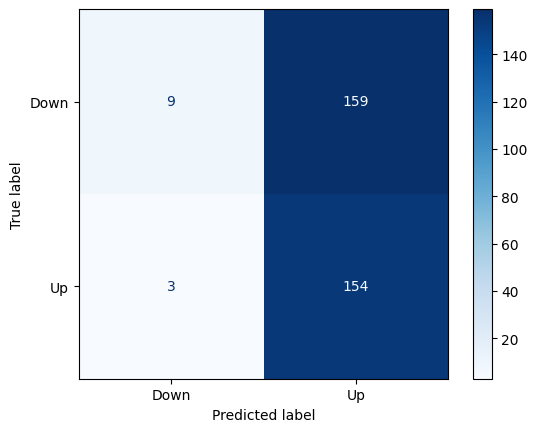

In [84]:
acc = model_diff.evaluate(x=X_test_diff, y=y_test_diff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_diff.predict(X_test_diff)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_diff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_diff, y_pred))

Try to train an MLP with default structure.

In [98]:
model_diff = build_MLP_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)

# fit the model
model_diff.fit(
    X_train_diff,
    y_train_diff,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
21/21 - 1s - loss: 0.6957 - accuracy: 0.4779 - val_loss: 0.6895 - val_accuracy: 0.5142 - 1s/epoch - 66ms/step
Epoch 2/500
21/21 - 0s - loss: 0.6891 - accuracy: 0.5479 - val_loss: 0.6883 - val_accuracy: 0.5284 - 81ms/epoch - 4ms/step
Epoch 3/500
21/21 - 0s - loss: 0.6852 - accuracy: 0.5662 - val_loss: 0.6914 - val_accuracy: 0.5035 - 81ms/epoch - 4ms/step
Epoch 4/500
21/21 - 0s - loss: 0.6818 - accuracy: 0.5677 - val_loss: 0.6921 - val_accuracy: 0.5000 - 89ms/epoch - 4ms/step
Epoch 5/500
21/21 - 0s - loss: 0.6775 - accuracy: 0.5814 - val_loss: 0.6967 - val_accuracy: 0.5071 - 97ms/epoch - 5ms/step
Epoch 6/500
21/21 - 0s - loss: 0.6714 - accuracy: 0.5936 - val_loss: 0.6946 - val_accuracy: 0.5142 - 87ms/epoch - 4ms/step
Epoch 7/500
21/21 - 0s - loss: 0.6648 - accuracy: 0.5997 - val_loss: 0.6999 - val_accuracy: 0.5284 - 77ms/epoch - 4ms/step
Epoch 8/500
21/21 - 0s - loss: 0.6581 - accuracy: 0.6149 - val_loss: 0.7043 - val_accuracy: 0.5284 - 79ms/epoch - 4ms/step
Epoch 9/500
21/21

11/11 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4954
Accuracy over test: 49.54%
11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.55      0.13      0.21       168
         1.0       0.49      0.89      0.63       157

    accuracy                           0.50       325
   macro avg       0.52      0.51      0.42       325
weighted avg       0.52      0.50      0.41       325



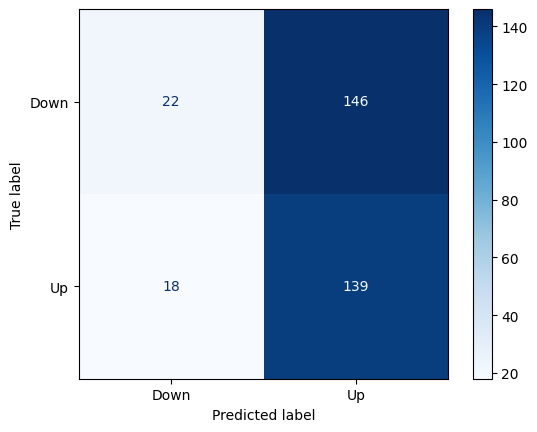

In [99]:
acc = model_diff.evaluate(x=X_test_diff, y=y_test_diff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_diff.predict(X_test_diff)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_diff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_diff, y_pred))

## Fractional Differencing

In [100]:
df1_label_fdiff = df1_fdiff.copy()
df1_label_fdiff['Label'] = df1_label[df1_label.index.isin(df1_fdiff.index)]['Label']
df1_label_fdiff.dropna(inplace=True)

df2_label_fdiff = df2_fdiff.copy()
df2_label_fdiff['Label'] = df2_label[df2_label.index.isin(df2_fdiff.index)]['Label']
df2_label_fdiff.dropna(inplace=True)

In [102]:
df1_feature_fdiff = add_features(df1_label_fdiff)
X_train_fdiff = df1_feature_fdiff[feature_lst].astype("float32")
y_train_fdiff = df1_feature_fdiff['Label'].astype("float32")

df2_feature_fdiff = add_features(df2_label_fdiff)
X_test_fdiff = df2_feature_fdiff[feature_lst].astype("float32")
y_test_fdiff = df2_feature_fdiff['Label'].astype("float32")
print(X_train_fdiff.shape, X_test_fdiff.shape, y_train_fdiff.shape, y_test_fdiff.shape)

(904, 20) (290, 20) (904,) (290,)


In [103]:
# First, we clear the session just to make sure our seeds are correctly working and replicability is achieved
K.clear_session()

# Then, we call the model and perform the tuning:
hypermodel = MLP_model()
tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_epochs=30,
    seed=1234,
    directory=os.path.normpath("/content/"),
)

# Let's run the tuner! (Warning: this could take time)
tuner.search(X_train_fdiff, y_train_fdiff, validation_split=0.3)
best_hps_fdiff = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 07s]
val_loss: 0.6835712790489197

Best val_loss So Far: 0.649255096912384
Total elapsed time: 00h 05m 57s


In [104]:
best_hps_fdiff.values

{'n_dropout': 0.2,
 'num_layers': 5,
 'units_dense_1': 40,
 'units_dense_2': 10,
 'units_dense_3': 50,
 'units_dense_4': 10,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

In [108]:
model_fdiff = tuner.hypermodel.build(best_hps_fdiff)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

# fit the model
model_fdiff.fit(
    X_train_fdiff,
    y_train_fdiff,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
20/20 - 3s - loss: 47.4651 - accuracy: 0.4810 - val_loss: 44.4854 - val_accuracy: 0.3566 - 3s/epoch - 165ms/step
Epoch 2/500
20/20 - 0s - loss: 56.1186 - accuracy: 0.4573 - val_loss: 42.6928 - val_accuracy: 0.3566 - 128ms/epoch - 6ms/step
Epoch 3/500
20/20 - 0s - loss: 46.1071 - accuracy: 0.4604 - val_loss: 40.9611 - val_accuracy: 0.3566 - 149ms/epoch - 7ms/step
Epoch 4/500
20/20 - 0s - loss: 44.5823 - accuracy: 0.4668 - val_loss: 39.2839 - val_accuracy: 0.3566 - 180ms/epoch - 9ms/step
Epoch 5/500
20/20 - 0s - loss: 46.8392 - accuracy: 0.4715 - val_loss: 37.3980 - val_accuracy: 0.3566 - 135ms/epoch - 7ms/step
Epoch 6/500
20/20 - 0s - loss: 43.3410 - accuracy: 0.4763 - val_loss: 35.4868 - val_accuracy: 0.3566 - 117ms/epoch - 6ms/step
Epoch 7/500
20/20 - 0s - loss: 40.0093 - accuracy: 0.4620 - val_loss: 33.6110 - val_accuracy: 0.3566 - 129ms/epoch - 6ms/step
Epoch 8/500
20/20 - 0s - loss: 41.6257 - accuracy: 0.4509 - val_loss: 31.6863 - val_accuracy: 0.3566 - 160ms/epoch - 8m

In [109]:
model_fdiff.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 40)                840       
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                550       
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 10)               

10/10 [==============================] - 0s 2ms/step - loss: 0.8214 - accuracy: 0.4828
Accuracy over test: 48.28%
10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       150
         1.0       0.48      1.00      0.65       140

    accuracy                           0.48       290
   macro avg       0.24      0.50      0.33       290
weighted avg       0.23      0.48      0.31       290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


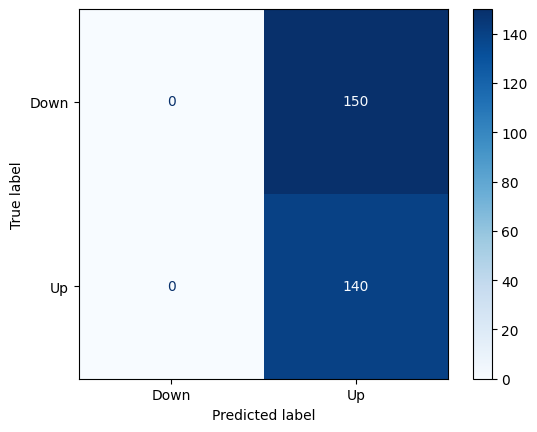

In [110]:
acc = model_fdiff.evaluate(x=X_test_fdiff, y=y_test_fdiff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_fdiff.predict(X_test_fdiff)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_fdiff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_fdiff, y_pred))

Again, try to train an MLP with default structure.

In [115]:
model_fdiff = build_MLP_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)

# fit the model
model_fdiff.fit(
    X_train_fdiff,
    y_train_fdiff,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
20/20 - 3s - loss: 1.3785 - accuracy: 0.5380 - val_loss: 0.7786 - val_accuracy: 0.3750 - 3s/epoch - 139ms/step
Epoch 2/500
20/20 - 0s - loss: 0.7456 - accuracy: 0.5285 - val_loss: 0.8292 - val_accuracy: 0.3566 - 85ms/epoch - 4ms/step
Epoch 3/500
20/20 - 0s - loss: 0.9138 - accuracy: 0.4810 - val_loss: 1.0445 - val_accuracy: 0.3566 - 100ms/epoch - 5ms/step
Epoch 4/500
20/20 - 0s - loss: 0.7687 - accuracy: 0.4921 - val_loss: 0.6596 - val_accuracy: 0.6324 - 81ms/epoch - 4ms/step
Epoch 5/500
20/20 - 0s - loss: 0.7459 - accuracy: 0.4953 - val_loss: 0.6656 - val_accuracy: 0.6434 - 87ms/epoch - 4ms/step
Epoch 6/500
20/20 - 0s - loss: 0.7580 - accuracy: 0.5016 - val_loss: 0.6707 - val_accuracy: 0.6434 - 80ms/epoch - 4ms/step
Epoch 7/500
20/20 - 0s - loss: 0.7162 - accuracy: 0.5237 - val_loss: 0.6959 - val_accuracy: 0.5037 - 87ms/epoch - 4ms/step
Epoch 8/500
20/20 - 0s - loss: 0.7212 - accuracy: 0.5127 - val_loss: 0.7125 - val_accuracy: 0.4375 - 76ms/epoch - 4ms/step
Epoch 9/500
20/

10/10 [==============================] - 0s 9ms/step - loss: 0.7283 - accuracy: 0.4828
Accuracy over test: 48.28%
10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       150
         1.0       0.48      1.00      0.65       140

    accuracy                           0.48       290
   macro avg       0.24      0.50      0.33       290
weighted avg       0.23      0.48      0.31       290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


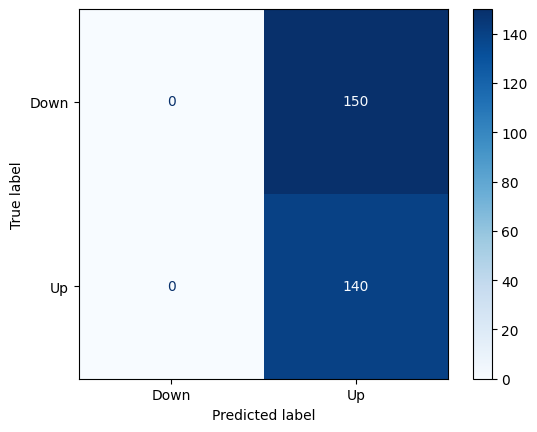

In [116]:
acc = model_fdiff.evaluate(x=X_test_fdiff, y=y_test_fdiff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_fdiff.predict(X_test_fdiff)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_fdiff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_fdiff, y_pred))

It hardly has any predictive power.

We will try again but this time, we substrct "Close" from the past information.

In [123]:
df1_feature_fdiff_zero = add_features(df1_label_fdiff, set_zero=True)
X_train_fdiff_zero = df1_feature_fdiff_zero[feature_lst[1:]].astype("float32")

df2_feature_fdiff_zero = add_features(df2_label_fdiff, set_zero=True)
X_test_fdiff_zero = df2_feature_fdiff_zero[feature_lst[1:]].astype("float32")

print(X_train_fdiff_zero.shape, X_test_fdiff_zero.shape)

(904, 19) (290, 19)


In [120]:
model_fdiff_zero = build_MLP_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)

# fit the model
model_fdiff_zero.fit(
    X_train_fdiff_zero,
    y_train_fdiff,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
20/20 - 2s - loss: 0.6998 - accuracy: 0.5427 - val_loss: 0.6744 - val_accuracy: 0.5809 - 2s/epoch - 120ms/step
Epoch 2/500
20/20 - 0s - loss: 0.6889 - accuracy: 0.5506 - val_loss: 0.6889 - val_accuracy: 0.5257 - 189ms/epoch - 9ms/step
Epoch 3/500
20/20 - 0s - loss: 0.6847 - accuracy: 0.5506 - val_loss: 0.6764 - val_accuracy: 0.5515 - 211ms/epoch - 11ms/step
Epoch 4/500
20/20 - 0s - loss: 0.6750 - accuracy: 0.5870 - val_loss: 0.6907 - val_accuracy: 0.5074 - 192ms/epoch - 10ms/step
Epoch 5/500
20/20 - 0s - loss: 0.6714 - accuracy: 0.5981 - val_loss: 0.6911 - val_accuracy: 0.5074 - 246ms/epoch - 12ms/step
Epoch 6/500
20/20 - 0s - loss: 0.6673 - accuracy: 0.6028 - val_loss: 0.6928 - val_accuracy: 0.5074 - 242ms/epoch - 12ms/step
Epoch 7/500
20/20 - 0s - loss: 0.6619 - accuracy: 0.5949 - val_loss: 0.6918 - val_accuracy: 0.4963 - 217ms/epoch - 11ms/step
Epoch 8/500
20/20 - 0s - loss: 0.6573 - accuracy: 0.6013 - val_loss: 0.7033 - val_accuracy: 0.4926 - 234ms/epoch - 12ms/step
Epo

10/10 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5241
Accuracy over test: 52.41%
10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.61      0.23      0.33       150
         1.0       0.50      0.84      0.63       140

    accuracy                           0.52       290
   macro avg       0.56      0.53      0.48       290
weighted avg       0.56      0.52      0.48       290



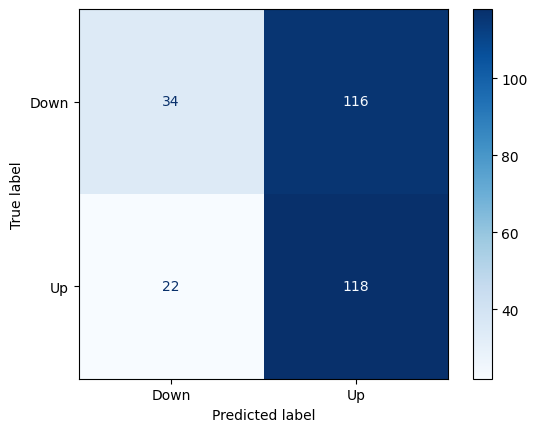

In [124]:
acc = model_fdiff_zero.evaluate(x=X_test_fdiff_zero, y=y_test_fdiff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_fdiff_zero.predict(X_test_fdiff_zero)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_fdiff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_fdiff, y_pred))

#GAF and CNN

## Original Time Series


In [125]:
window_size = 20

In [126]:
def create_gaf_dataset(df_label, plot=False):
  X = []
  for i in range(window_size, df_label.shape[0]):
      X.append(df_label['Close'][i - window_size : i])
  X = np.array(X)
  print(X.shape)
  y = df_label['Label'][window_size:]
  print(y.shape)

  if plot:
    # Define a "window_size"-days interval
    days = np.linspace(1, X.shape[0], num=X.shape[0])
    # Plot the overlapping time series
    plt.figure(figsize=(6, 6))
    for i in range(100):
        plt.plot(days[i : window_size + i], X[i, :])

  return X, y

(939, 20)
(939,)


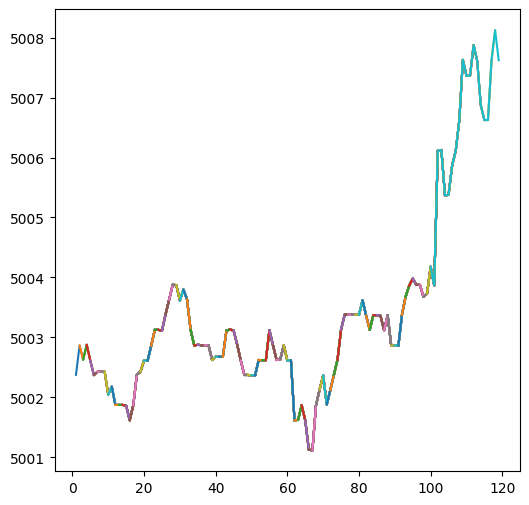

In [127]:
X_train_gaf, y_train_gaf = create_gaf_dataset(df1_label, plot=True)

In [128]:
transformer = GramianAngularField()
X_train_gaf_new = transformer.transform(X_train_gaf)
print(X_train_gaf_new.shape)

(939, 20, 20)


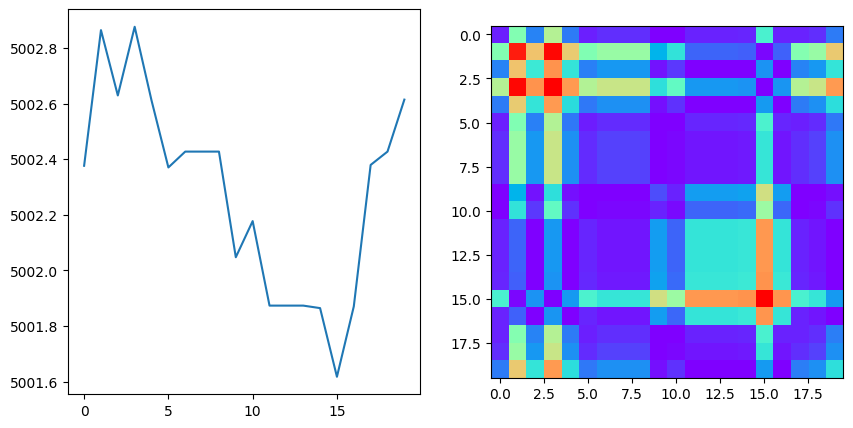

In [129]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf[0, :])
ax[1].imshow(X_train_gaf_new[0], cmap="rainbow")

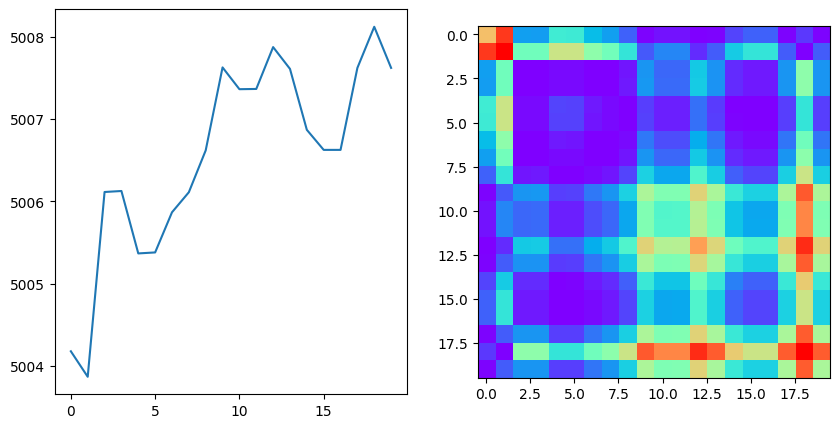

In [130]:
# Show the results for the 100th time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf[99, :])
ax[1].imshow(X_train_gaf_new[99], cmap="rainbow")

In [131]:
X_test_gaf, y_test_gaf = create_gaf_dataset(df2_label)
transformer = GramianAngularField()
X_test_gaf_new = transformer.transform(X_test_gaf)
print(X_test_gaf_new.shape)

(325, 20)
(325,)
(325, 20, 20)


In [158]:
def build_CNN_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = tf.keras.Sequential()
    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(20, 20, 1)))
    model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    # model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
    # model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(1024, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5, seed=1234))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

    return model

In [159]:
model_gaf = build_CNN_model()
model_gaf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               1

In [162]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)

model_gaf.fit(
    X_train_gaf_new * 255.0,
    y_train_gaf,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
24/24 - 0s - loss: 0.7259 - accuracy: 0.5925 - val_loss: 0.8676 - val_accuracy: 0.5479 - 444ms/epoch - 18ms/step
Epoch 2/500
24/24 - 0s - loss: 0.6919 - accuracy: 0.5779 - val_loss: 0.7999 - val_accuracy: 0.5160 - 315ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 0.6454 - accuracy: 0.6218 - val_loss: 0.8300 - val_accuracy: 0.4468 - 290ms/epoch - 12ms/step
Epoch 4/500
24/24 - 0s - loss: 0.6086 - accuracy: 0.6591 - val_loss: 0.8116 - val_accuracy: 0.4362 - 316ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 0.5997 - accuracy: 0.6551 - val_loss: 0.8367 - val_accuracy: 0.5638 - 271ms/epoch - 11ms/step
Epoch 6/500
24/24 - 0s - loss: 0.5674 - accuracy: 0.6738 - val_loss: 0.9210 - val_accuracy: 0.4894 - 285ms/epoch - 12ms/step
Epoch 7/500
24/24 - 0s - loss: 0.5572 - accuracy: 0.6844 - val_loss: 0.8970 - val_accuracy: 0.4415 - 277ms/epoch - 12ms/step
Epoch 8/500
24/24 - 0s - loss: 0.5390 - accuracy: 0.6858 - val_loss: 1.0146 - val_accuracy: 0.5213 - 274ms/epoch - 11ms/step


11/11 [==============================] - 0s 4ms/step - loss: 1.0633 - accuracy: 0.5046
Accuracy over test: 50.46%
11/11 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.52      0.49      0.50       168
         1.0       0.49      0.52      0.50       157

    accuracy                           0.50       325
   macro avg       0.51      0.51      0.50       325
weighted avg       0.51      0.50      0.50       325



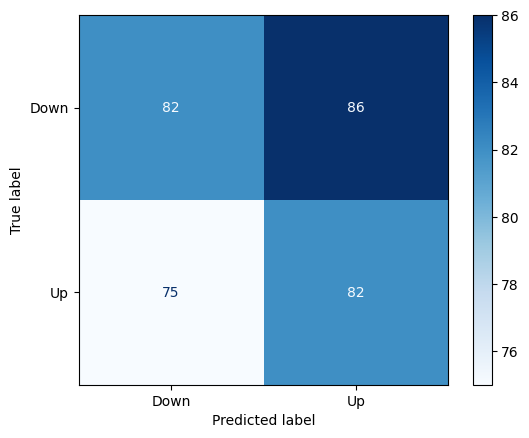

In [164]:
acc = model_gaf.evaluate(x=X_test_gaf_new * 255.0, y=y_test_gaf)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_gaf.predict(X_test_gaf_new * 255.0)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_gaf, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_diff, y_pred))

## Stationary Time Series

In [165]:
X_train_gaf_diff, y_train_gaf_diff = create_gaf_dataset(df1_label_diff)
transformer = GramianAngularField()
X_train_gaf_diff_new = transformer.transform(X_train_gaf_diff)
print(X_train_gaf_diff_new.shape)

(938, 20)
(938,)
(938, 20, 20)


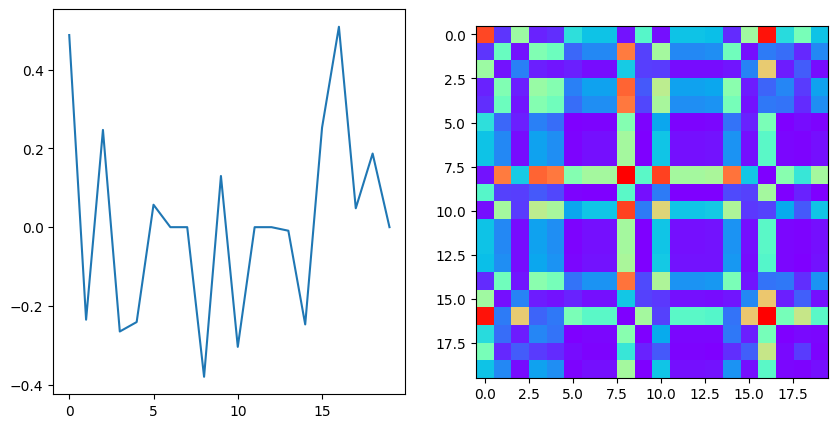

In [166]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf_diff[0, :])
ax[1].imshow(X_train_gaf_diff_new[0], cmap="rainbow")

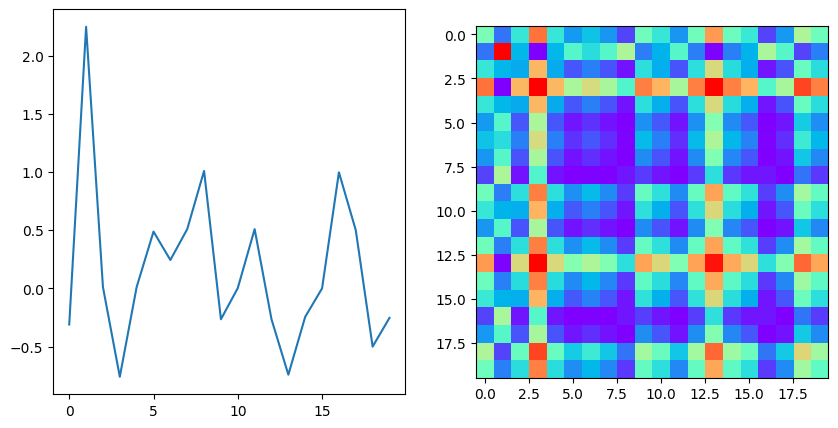

In [167]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf_diff[99, :])
ax[1].imshow(X_train_gaf_diff_new[99], cmap="rainbow")

In [172]:
X_test_gaf_diff, y_test_gaf_diff = create_gaf_dataset(df2_label_diff)
transformer = GramianAngularField()
X_test_gaf_diff_new = transformer.transform(X_test_gaf_diff)
print(X_test_gaf_diff_new.shape)

(324, 20)
(324,)
(324, 20, 20)


In [176]:
model_gaf_diff = build_CNN_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)
model_gaf_diff.fit(
    X_train_gaf_diff_new * 255.0,
    y_train_gaf_diff,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
24/24 - 1s - loss: 12.9925 - accuracy: 0.5173 - val_loss: 1.2151 - val_accuracy: 0.4947 - 1s/epoch - 52ms/step
Epoch 2/500
24/24 - 0s - loss: 1.1639 - accuracy: 0.5027 - val_loss: 0.7203 - val_accuracy: 0.5266 - 319ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 0.7393 - accuracy: 0.5440 - val_loss: 0.6808 - val_accuracy: 0.6223 - 322ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 0.6689 - accuracy: 0.5587 - val_loss: 0.7166 - val_accuracy: 0.5372 - 322ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 0.6775 - accuracy: 0.5707 - val_loss: 0.7153 - val_accuracy: 0.5904 - 286ms/epoch - 12ms/step
Epoch 6/500
24/24 - 0s - loss: 0.6834 - accuracy: 0.5853 - val_loss: 0.7160 - val_accuracy: 0.6170 - 321ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 0.6347 - accuracy: 0.6160 - val_loss: 0.7084 - val_accuracy: 0.5798 - 332ms/epoch - 14ms/step
Epoch 8/500
24/24 - 0s - loss: 0.6034 - accuracy: 0.6227 - val_loss: 0.6998 - val_accuracy: 0.4947 - 315ms/epoch - 13ms/step
Ep

11/11 [==============================] - 0s 8ms/step - loss: 0.7333 - accuracy: 0.4599
Accuracy over test: 45.99%
11/11 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

         0.0       0.45      0.22      0.29       167
         1.0       0.46      0.72      0.56       157

    accuracy                           0.46       324
   macro avg       0.46      0.47      0.43       324
weighted avg       0.46      0.46      0.42       324



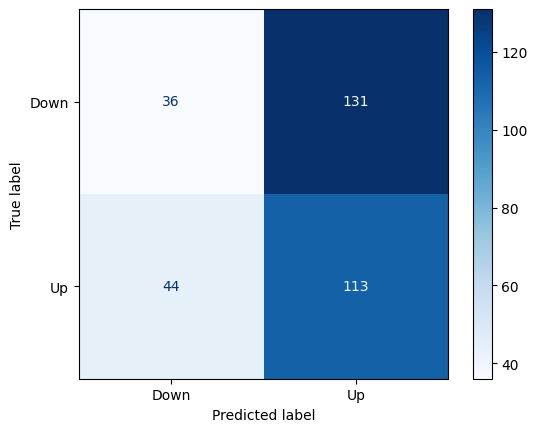

In [177]:
acc = model_gaf_diff.evaluate(x=X_test_gaf_diff_new * 255.0, y=y_test_gaf_diff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_gaf_diff.predict(X_test_gaf_diff_new * 255.0)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_gaf_diff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_gaf_diff, y_pred))

## Fractional Differencing

In [178]:
X_train_gaf_fdiff, y_train_gaf_fdiff = create_gaf_dataset(df1_label_fdiff)
transformer = GramianAngularField()
X_train_gaf_fdiff_new = transformer.transform(X_train_gaf_fdiff)
print(X_train_gaf_fdiff_new.shape)

(903, 20)
(903,)
(903, 20, 20)


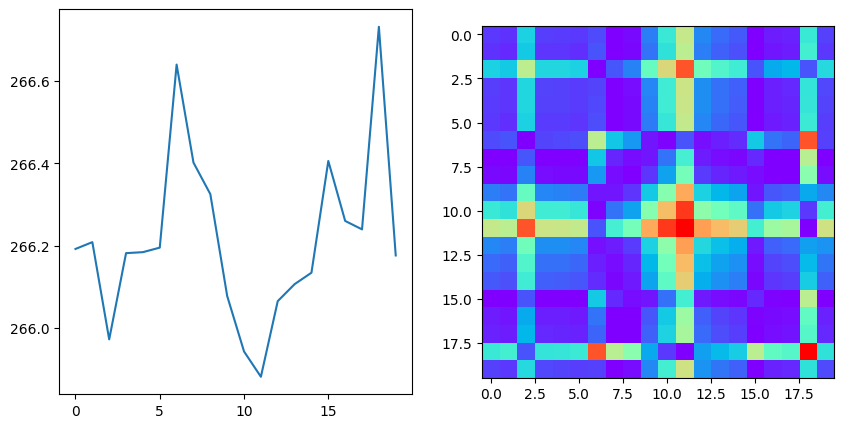

In [179]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf_fdiff[0, :])
ax[1].imshow(X_train_gaf_fdiff_new[0], cmap="rainbow")

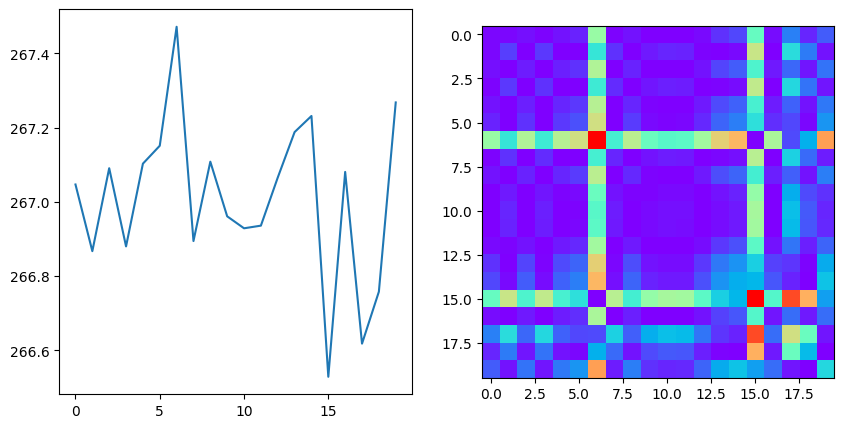

In [180]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train_gaf_fdiff[99, :])
ax[1].imshow(X_train_gaf_fdiff_new[99], cmap="rainbow")

In [181]:
X_test_gaf_fdiff, y_test_gaf_fdiff = create_gaf_dataset(df2_label_fdiff)
transformer = GramianAngularField()
X_test_gaf_fdiff_new = transformer.transform(X_test_gaf_fdiff)
print(X_test_gaf_fdiff_new.shape)

(289, 20)
(289,)
(289, 20, 20)


In [184]:
model_gaf_fdiff = build_CNN_model()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=30, restore_best_weights=True
)
model_gaf_fdiff.fit(
    X_train_gaf_fdiff_new * 255.0,
    y_train_gaf_fdiff,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
23/23 - 2s - loss: 9.1039 - accuracy: 0.5235 - val_loss: 1.0214 - val_accuracy: 0.4530 - 2s/epoch - 80ms/step
Epoch 2/500
23/23 - 0s - loss: 1.0930 - accuracy: 0.5277 - val_loss: 0.7487 - val_accuracy: 0.4917 - 463ms/epoch - 20ms/step
Epoch 3/500
23/23 - 0s - loss: 0.7468 - accuracy: 0.5665 - val_loss: 0.7531 - val_accuracy: 0.5249 - 401ms/epoch - 17ms/step
Epoch 4/500
23/23 - 0s - loss: 0.7217 - accuracy: 0.5803 - val_loss: 0.6924 - val_accuracy: 0.5856 - 409ms/epoch - 18ms/step
Epoch 5/500
23/23 - 0s - loss: 0.6569 - accuracy: 0.5873 - val_loss: 0.7000 - val_accuracy: 0.6133 - 375ms/epoch - 16ms/step
Epoch 6/500
23/23 - 0s - loss: 0.6469 - accuracy: 0.6163 - val_loss: 0.6723 - val_accuracy: 0.6077 - 429ms/epoch - 19ms/step
Epoch 7/500
23/23 - 0s - loss: 0.6308 - accuracy: 0.6288 - val_loss: 0.8545 - val_accuracy: 0.5249 - 452ms/epoch - 20ms/step
Epoch 8/500
23/23 - 0s - loss: 0.6409 - accuracy: 0.6440 - val_loss: 0.9102 - val_accuracy: 0.5746 - 412ms/epoch - 18ms/step
Epo

10/10 [==============================] - 0s 4ms/step - loss: 0.8838 - accuracy: 0.4983
Accuracy over test: 49.83%
10/10 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.11      0.18       149
         1.0       0.49      0.91      0.64       140

    accuracy                           0.50       289
   macro avg       0.53      0.51      0.41       289
weighted avg       0.53      0.50      0.40       289



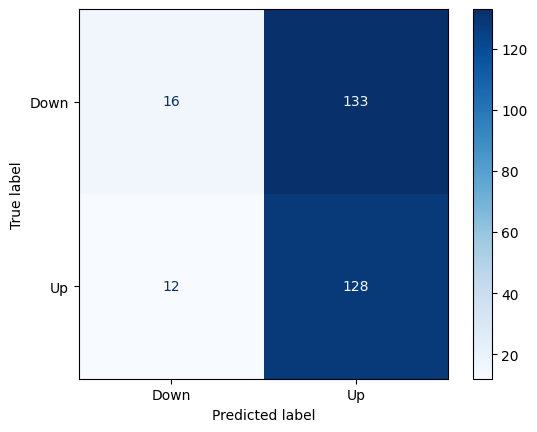

In [185]:
acc = model_gaf_fdiff.evaluate(x=X_test_gaf_fdiff_new * 255.0, y=y_test_gaf_fdiff)
print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

y_prob = model_gaf_fdiff.predict(X_test_gaf_fdiff_new * 255.0)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test_gaf_fdiff, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test_gaf_fdiff, y_pred))